In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation, Input, Dropout
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomZoom, RandomHeight, RandomWidth
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import random
import datetime
import os
import zipfile

In [2]:
# достаем данные из kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

 90% 89.0M/98.7M [00:01<00:00, 94.7MB/s]
100% 98.7M/98.7M [00:01<00:00, 78.8MB/s]


In [3]:
# Функция для разархивирования
def unzip_data(filename):
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [4]:
unzip_data('melanoma-skin-cancer-dataset-of-10000-images.zip')

In [5]:
train_dir = 'melanoma_cancer_dataset/train'
test_dir = 'melanoma_cancer_dataset/test'

train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                         image_size=(224, 224),
                                                         label_mode='binary',
                                                         seed=0)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                        image_size=(224, 224),
                                                        label_mode='binary',
                                                        seed=0)

Found 9605 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [6]:
# смотрим какие классы есть

class_names = train_data.class_names
num_classes = len(class_names)
print("The dataset contains the following {} classes: {}".format(num_classes, class_names))

The dataset contains the following 2 classes: ['benign', 'malignant']


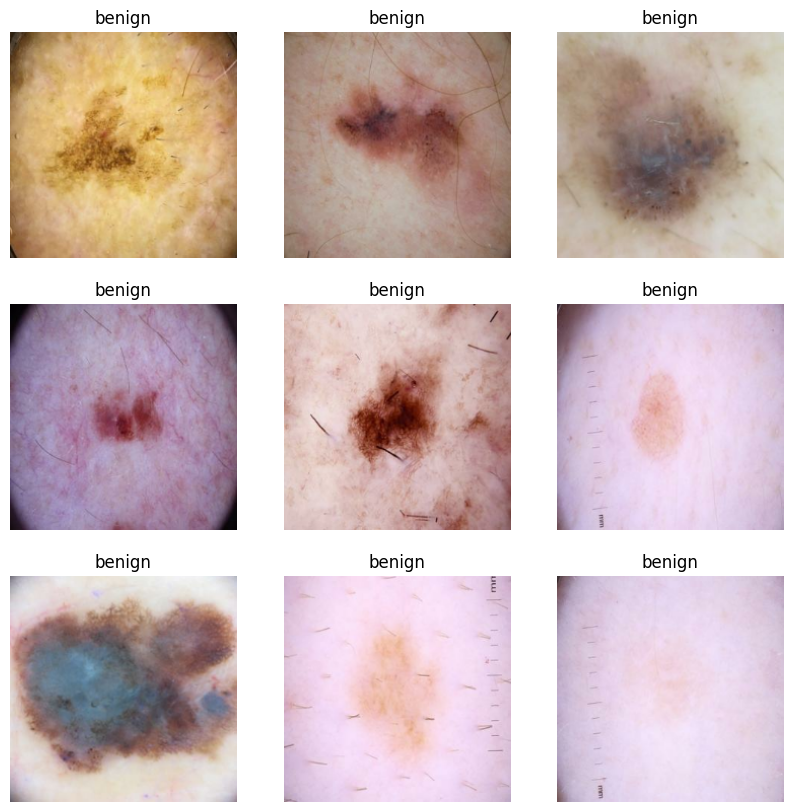

In [7]:
# Делаем visualization из рандомных изображений из тренировочного датасета

plt.figure(figsize=(10, 10))

random_batch_num = random.randint(1, len(train_data))

for images, labels in train_data.take(random_batch_num):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis('off')

In [8]:
# Видоизменяем данные чтобы уменьшить overfitting

data_augmentation = keras.Sequential([
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomWidth(0.2),
    RandomHeight(0.2),
    RandomFlip('horizontal')
])

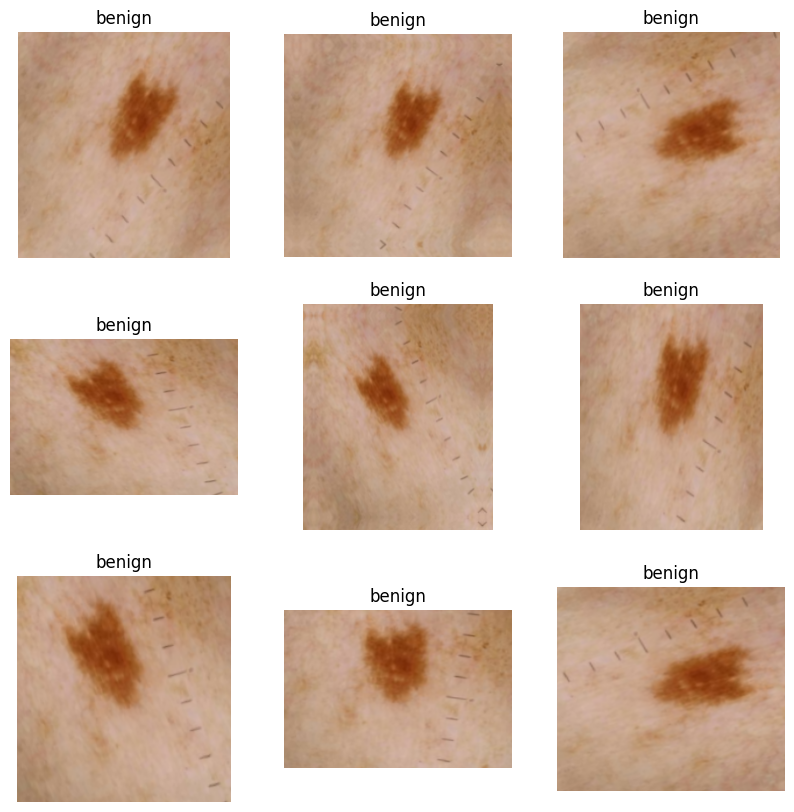

In [9]:
# Visualization для измененных данных

plt.figure(figsize=(10, 10))
random_batch_num = random.randint(1, len(train_data))
for images, labels in train_data.take(random_batch_num):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    augmented_images = data_augmentation(images)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.title(class_names[tf.argmax(labels[0])])
    plt.axis('off')

In [10]:
# prefetch
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

In [11]:
# Функция для создания callback для визуализации в Tensorboard
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [12]:
# Используем mixed precision для более быстрых вычислений

mixed_precision.set_global_policy('mixed_float16')
print(mixed_precision.global_policy)

<function global_policy at 0x79b122851d80>


In [13]:
# создаем модель на основе EfficientNetV2

base_model = keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

input_shape = (224, 224, 3)

inputs = Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2, name='dropout_layer_1')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2, name='dropout_layer_2')(x)
x = Dense(1)(x)

outputs = Activation('sigmoid', dtype=tf.float32, name='output_layer')(x)

model = keras.Model(inputs, outputs)


24274472/24274472 [==============================] - 0s 0us/step


In [14]:
# Компилируем модель

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
history = model.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    callbacks=[create_tensorboard_callback(dir_name='skin-cancer-detection',
                                                           experiment_name='feature_extraction_training')])

Saving TensorBoard log files to: skin-cancer-detection/feature_extraction_training/20230913-183633
Epoch 1/10
301/301 [==============================] - 129s 371ms/step - loss: 0.3079 - accuracy: 0.8619
Epoch 2/10
301/301 [==============================] - 87s 289ms/step - loss: 0.2432 - accuracy: 0.9017
Epoch 3/10
301/301 [==============================] - 71s 233ms/step - loss: 0.2274 - accuracy: 0.9067
Epoch 4/10
301/301 [==============================] - 62s 204ms/step - loss: 0.2160 - accuracy: 0.9124
Epoch 5/10
301/301 [==============================] - 61s 203ms/step - loss: 0.2110 - accuracy: 0.9126
Epoch 6/10
301/301 [==============================] - 49s 161ms/step - loss: 0.2068 - accuracy: 0.9169
Epoch 7/10
301/301 [==============================] - 49s 163ms/step - loss: 0.2071 - accuracy: 0.9150
Epoch 8/10
301/301 [==============================] - 45s 150ms/step - loss: 0.1905 - accuracy: 0.9258
Epoch 9/10
301/301 [==============================] - 43s 142ms/step - loss:

In [16]:
# результаты модели на test dataset

model_test_results = model.evaluate(test_data)

32/32 [==============================] - 3s 45ms/step - loss: 0.2571 - accuracy: 0.9000


In [17]:
# Функция для импорта и изменения изображения для загрузку в модель
def load_and_prep_image(filename, img_shape=224):
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img)
  img = tf.image.resize(img, [img_shape, img_shape])

  return img

In [18]:
# Функция для проверки модели на случайном изображении предоставленным пользователем
def pred_and_plot(model, filename, class_names, actual_class):

  img = load_and_prep_image(filename)

  pred = model.predict(tf.expand_dims(img, axis=0))

  if len(pred[0]) > 1:
    pred_class = class_names[pred.argmax()]
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])]

  plt.imshow(img/255)
  plt.title(f"Prediction: {pred_class}, Actual: {actual_class}")
  plt.axis(False);

1/1 [==============================] - 2s 2s/step


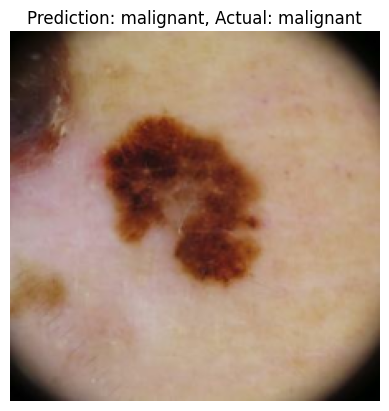

In [19]:
# тестируем модель на рандомном изображении из тестового датасета
random_class = random.choice(class_names)
random_image = random.choice(os.listdir(os.path.join('melanoma_cancer_dataset/test/', random_class)))
random_image_path = os.path.join('melanoma_cancer_dataset/test', random_class, random_image)
pred_and_plot(model=model,
              filename=random_image_path,
              class_names=class_names,
              actual_class=random_class)

In [20]:
# сохраняем модель
model.save('skin-cancer-detection-model.keras')